# Applied Machine Learning: Homework Exercise Imputation

## Goal

Our goal for this homework is to learn the basics of imputation using Python's scikit-learn library. Imputation is the process of filling in missing data in a dataset using statistical methods such as mean, median, mode, or predictive models.

## Required packages
We will use scikit-learn for machine learning and data access from OpenML. 

## Data: Washington bike rentals

We will use bike-sharing data for 731 days in Washington, D.C., where the target variable to predict is rentals.
Load the data and remove the unwanted column atemp. Additionally, artificially generate missing values for the feature temp.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

rng = np.random.default_rng(12345)

X, y = fetch_openml(data_id=45103, as_frame=True, return_X_y=True)

# OpenML treats this dataset as a classification dataset, so y is categorical by default.
# We need to cast y to float
y = y.astype(float)

X.drop(columns=['atemp'], inplace=True)


# Artificially introduce 300 missing values into “temp”
mask_idx = rng.choice(X.shape[0], size=300, replace=False)
X.loc[mask_idx, 'temp'] = np.nan

print(f"Missing in 'temp': {X['temp'].isna().sum()} rows")

Missing in 'temp': 300 rows


## Compare different learners

In this exercise, we want to compare the performance of two learners used to impute the missing values in `temp`: a linear regression model (LM) and a k-nearest neighbor imputer (kNN), where we want to tune the hyperparameter `k`. We will benchmark the performance of a pipeline that connects these different imputation methods with a `RandomForestRegressor`.

## Construct a pipeline

Since there is no direct equivalent in scikit-learn for branching pipelines (unlike in `mlr3`), we use the same trick as before: we first create a Pipeline with a placeholder imputer, and then we switch between different imputers by defining them as hyperparameters in the parameter search space.


In [2]:
#===SOLUTION===

from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create main pipeline with a placeholder imputer
pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=12345)),  # placeholder imputer
    ('model', RandomForestRegressor(random_state=12345))
])

# Display the pipeline graph
pipeline

Pipeline(steps=[('imputer', IterativeImputer(random_state=12345)),
                ('model', RandomForestRegressor(random_state=12345))])

## Tunable hyperparameters

We want to tune two main hyperparameters in the pipeline:

1. The imputation method: This involves choosing between the linear regression-based iterative imputer and the k-nearest neighbor (kNN)-based iterative imputer.

2. The number of neighbors (k) for the kNN-based imputation method: We will consider values from 1 to 8.

Define an appropriate hyperparameter grid.

<details><summary>Hint 1:</summary>

You can specify the KNN's `k` via the key `imputer__estimator__n_neighbors`, if you have used the key `"imputer"` for the placeholder imputer in the pipeline.

</details>

In [3]:
#===SOLUTION===

from sklearn.neighbors import KNeighborsRegressor


# Define the hyperparameter grid with nested parameter specification
param_grid = [
    {
        'imputer': [IterativeImputer(
            estimator=LinearRegression(),
            initial_strategy='mean',
            random_state=12345,
            imputation_order='random'
        )]
    },
    {
        'imputer': [IterativeImputer(
            estimator=KNeighborsRegressor(),
            initial_strategy='mean',
            random_state=12345,
            imputation_order='random'
        )],
        'imputer__estimator__n_neighbors': list(range(1, 9))
    }
]

print(f"Parameter grid for GridSearchCV: {param_grid}")

Parameter grid for GridSearchCV: [{'imputer': [IterativeImputer(estimator=LinearRegression(), imputation_order='random',
                 random_state=12345)]}, {'imputer': [IterativeImputer(estimator=KNeighborsRegressor(), imputation_order='random',
                 random_state=12345)], 'imputer__estimator__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]}]


## Tune the pipeline

Your task is now to tune the pipeline you've constructed by performing a grid search over the previously defined parameter space. Use a 4-fold CV repeated 3 times, with MSE as the performance measure.

In [4]:
#===SOLUTION===

from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=12345)

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

search.fit(X, y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=4, random_state=12345),
             estimator=Pipeline(steps=[('imputer',
                                        IterativeImputer(random_state=12345)),
                                       ('model',
                                        RandomForestRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'imputer': [IterativeImputer(estimator=LinearRegression(),
                                                       imputation_order='random',
                                                       random_state=12345)]},
                         {'imputer': [IterativeImputer(estimator=KNeighborsRegressor(),
                                                       imputation_order='random',
                                                       random_state=12345)],
                          'imputer__estimator__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                              7, 8]}],
             scoring='neg_mean_squared_error')

## Visualize the results

Retrieve the performance values associated with each imputation method from the `cv_results_` attribute of your fitted `GridSearchCV` object.
Your task is to compare: The MSE for the Linear Regression-based iterative imputer. The MSE for the kNN-based iterative imputer (using the default k=5). The effect of different values of k on the MSE for the kNN-based iterative imputer.

Lastly, identify and report the best hyperparameter configuration found during grid search.

Mean Squared Error (MSE) for each imputation method:
--------------------------------------------------
Linear imputation MSE: 108283.8996 ± 18593.6585

KNN imputation MSE by n_neighbors:
n_neighbors = 1.0: 111506.2090 ± 24799.3340
n_neighbors = 2.0: 106982.6790 ± 22709.3643
n_neighbors = 3.0: 107452.8954 ± 25450.1036
n_neighbors = 4.0: 106508.2130 ± 22565.1998
n_neighbors = 5.0: 105072.9993 ± 20350.3733
n_neighbors = 6.0: 107642.7770 ± 19289.8477
n_neighbors = 7.0: 105454.8032 ± 20286.3023
n_neighbors = 8.0: 105939.5429 ± 19314.5824


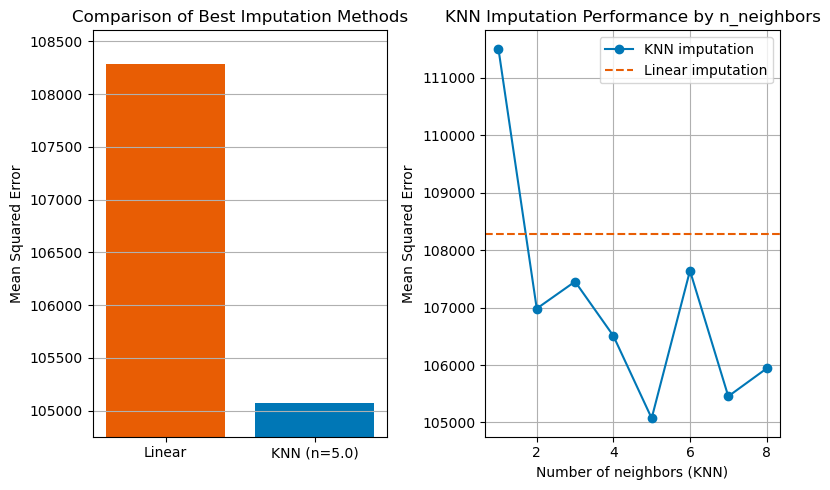


Best imputation method:
Parameters: {'imputer': IterativeImputer(estimator=KNeighborsRegressor(), imputation_order='random',
                 random_state=12345), 'imputer__estimator__n_neighbors': 5}
MSE: 105072.9993


In [5]:
#===SOLUTION===

import matplotlib.pyplot as plt

# Convert the CV results to a DataFrame for easier analysis
results = pd.DataFrame(search.cv_results_)

# Extract the MSE values (convert from negative to positive)
results['mean_test_mse'] = -results['mean_test_score']
results['std_test_mse'] = results['std_test_score']

print("Mean Squared Error (MSE) for each imputation method:")
print("-" * 50)

linear_results = results[results['param_imputer'].apply(lambda x: 'LinearRegression' in str(x))]
knn_results = results[results['param_imputer'].apply(lambda x: 'KNeighborsRegressor' in str(x))]

print(f"Linear imputation MSE: {linear_results['mean_test_mse'].values[0]:.4f} ± {linear_results['std_test_mse'].values[0]:.4f}")

# KNN imputation results
print("\nKNN imputation MSE by n_neighbors:")
for i, row in knn_results.iterrows():
    n_neighbors = row['param_imputer__estimator__n_neighbors']
    mse = row['mean_test_mse']
    std = row['std_test_mse']
    print(f"n_neighbors = {n_neighbors}: {mse:.4f} ± {std:.4f}")


plt.figure(figsize=(8, 5))

# Bar plot comparing linear vs best KNN
plt.subplot(1, 2, 1)
best_knn_idx = knn_results['mean_test_mse'].idxmin()
best_knn_n = knn_results.loc[best_knn_idx, 'param_imputer__estimator__n_neighbors']
best_knn_mse = knn_results.loc[best_knn_idx, 'mean_test_mse']
best_knn_std = knn_results.loc[best_knn_idx, 'std_test_mse']

methods = ['Linear', f'KNN (n={best_knn_n})']
mse_values = [linear_results['mean_test_mse'].values[0], best_knn_mse]

colors = ['#e85d04', '#0077b6']  # Soft orange for Linear, moderate blue for KNN
plt.bar(methods, mse_values, color=colors)
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Best Imputation Methods')
plt.grid(axis='y')

# Set ylim to make difference more obvious
min_mse = min(mse_values)
max_mse = max(mse_values)
range_mse = max_mse - min_mse
plt.ylim(min_mse - 0.1 * range_mse, max_mse + 0.1 * range_mse)

# Plot for KNN with different n_neighbors
plt.subplot(1, 2, 2)
n_neighbors = knn_results['param_imputer__estimator__n_neighbors'].values
mse_values = knn_results['mean_test_mse'].values

plt.plot(n_neighbors, mse_values, marker='o', linestyle='-', color=colors[1], label='KNN imputation')
plt.axhline(y=linear_results['mean_test_mse'].values[0], color=colors[0], linestyle='--', label='Linear imputation')
plt.xlabel('Number of neighbors (KNN)')
plt.ylabel('Mean Squared Error')
plt.title('KNN Imputation Performance by n_neighbors')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Print the best parameters and score
print("\nBest imputation method:")
print(f"Parameters: {search.best_params_}")
print(f"MSE: {-search.best_score_:.4f}")

Question: what is your observation?

===SOLUTION===

Unlike the R version, here the KNN-based imputation outperforms the LM-based approach. This difference may arise from subtle implementation distinctions between scikit-learn's `IterativeImputer` and mlr3's `imputelearner`.